# Explore here

# Bloque 1: Carga de librerías y datos

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import zscore
from scipy.stats import loguniform
import xgboost as xgb

#00. Importar librerías necesarias

#Cargar el dataset desde la URL
url = "https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv"
df = pd.read_csv(url, delimiter=";")

# Guardamos una copia local del DataFrame por si queremos inspeccionarlo fuera del entorno
df.to_csv("/workspaces/JAS_Logistic_Regression_Project_Tutorial.csv", index=False)


# Bloque 2: Exploración inicial del DataFrame

In [84]:
#01. Confirmamos la carga mostrando las primeras filas
df.head() 

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [85]:
#02. Dimensiones del DataFrame
# Esto nos dice cuántas filas (observaciones) y columnas (variables) tenemos en total
df.shape
print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

El dataset tiene 41188 filas y 21 columnas.


In [86]:
#03. Información general del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [87]:
# 04. Estadísticas descriptivas
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [88]:
#05. Número de valores únicos por columna
df.nunique().sort_values(ascending=False)

duration          1544
euribor3m          316
age                 78
campaign            42
pdays               27
cons.price.idx      26
cons.conf.idx       26
job                 12
nr.employed         11
emp.var.rate        10
month               10
education            8
previous             8
day_of_week          5
marital              4
default              3
housing              3
poutcome             3
loan                 3
contact              2
y                    2
dtype: int64

# Bloque 3. Limpieza Inicial del DataFrame

In [89]:
#06. Eliminar columnas con valores constantes

# Identificar columnas con un solo valor único
cols_constantes = df.nunique()[df.nunique() == 1].index

# Eliminar estas columnas del DataFrame
df = df.drop(columns=cols_constantes)

print(f"Columnas eliminadas: {list(cols_constantes)}")

Columnas eliminadas: []


In [90]:
# 07 - Comprobar la presencia de filas duplicadas
duplicados = df.duplicated().sum()
print(f"Filas duplicadas encontradas: {duplicados}")

if duplicados > 0:
    df = df.drop_duplicates()
    print(f"Se eliminaron {duplicados} duplicados. Tamaño final: {df.shape}")

Filas duplicadas encontradas: 12
Se eliminaron 12 duplicados. Tamaño final: (41176, 21)


# Bloque 4. Exploración de Variables

In [91]:
# 08. Identificar y explorar columnas categóricas y numéricas
# Esto nos permite revisar qué categorías contiene cada una, su distribución y relación con la variable objetivo 'y'

# Identificar columnas categóricas y numéricas
variables_numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
variables_categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Variables numéricas:", variables_numericas)
print("Variables categóricas:", variables_categoricas)

# Mostrar los valores únicos de cada variable categórica
for col in variables_categoricas:
    print(f"{col} → {df[col].unique()}")

# Análisis de "unknown" en variables categóricas
for col in variables_categoricas:
    if 'unknown' in df[col].values:
        porcentaje = (df[col] == 'unknown').mean() * 100
        print(f"{col}: {porcentaje:.2f}% 'unknown'")

Variables numéricas: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Variables categóricas: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
job → ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital → ['married' 'single' 'divorced' 'unknown']
education → ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default → ['no' 'unknown' 'yes']
housing → ['no' 'yes' 'unknown']
loan → ['no' 'yes' 'unknown']
contact → ['telephone' 'cellular']
month → ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week → ['mon' 'tue' 'wed' 'thu' 'fri']
poutcome → ['nonexistent' 'failure' 'success']
y → ['no' 'yes']
job: 0.80% 'unknown'
marital: 0.19% 'unknown'
education: 4.20% '

In [92]:
# 09. Eliminar columnas

# La columna 'duration' introduce data leakage, así que la eliminamos
columnas_irrelevantes = ['duration']
df = df.drop(columns=columnas_irrelevantes)

print(f"Columnas eliminadas por data leakage: {columnas_irrelevantes}")

Columnas eliminadas por data leakage: ['duration']


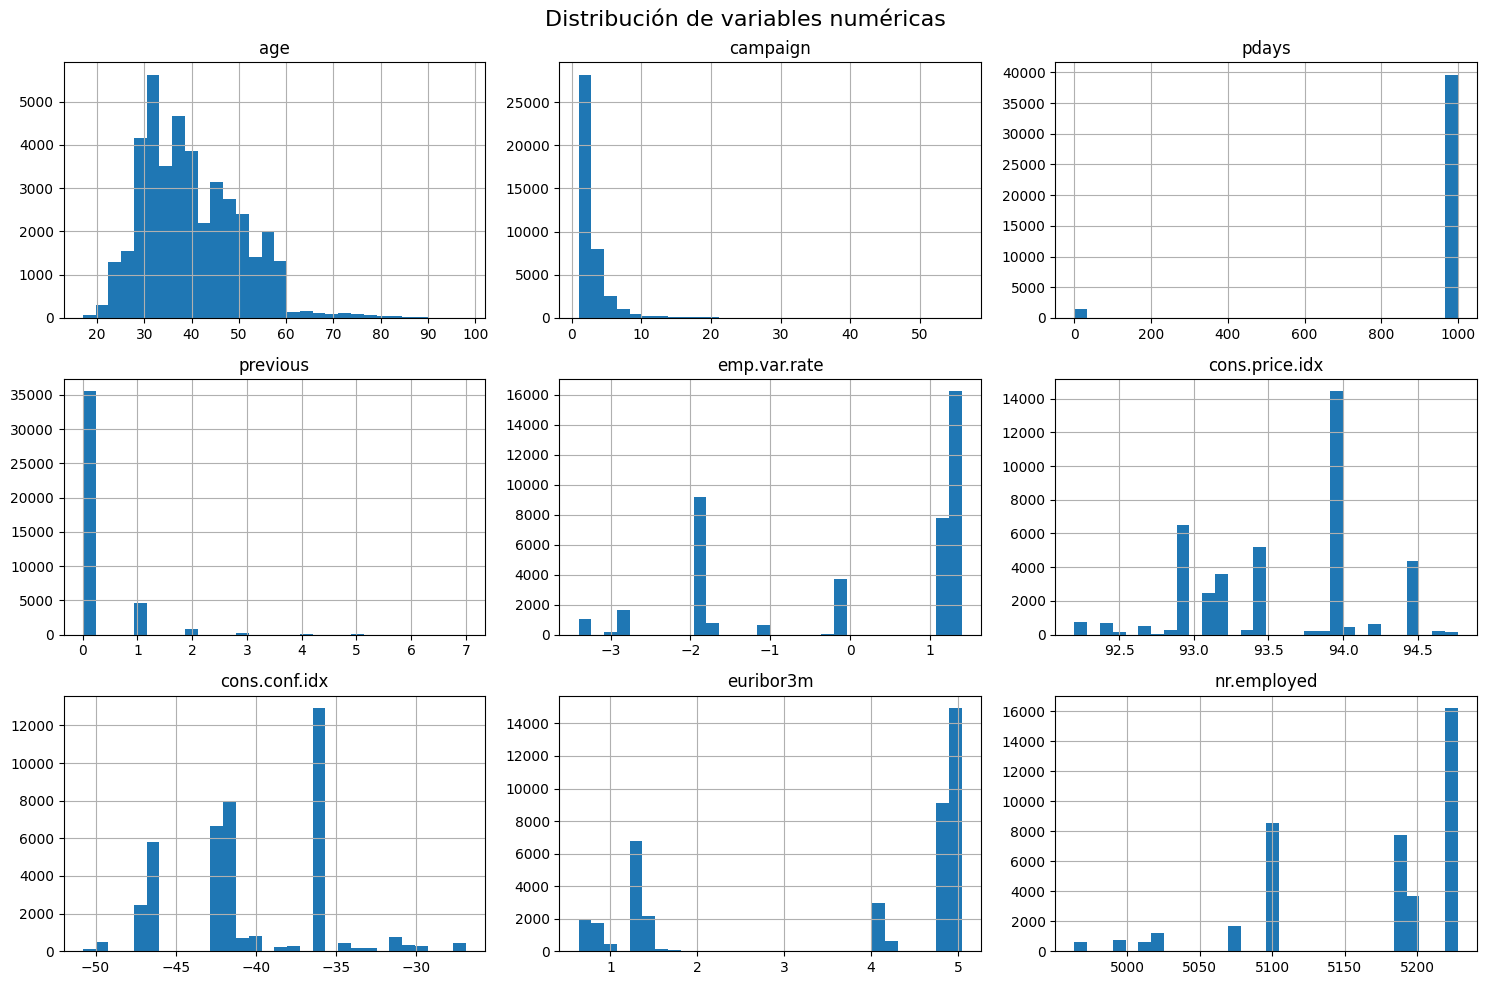

In [93]:
# 10. Visualización de variables numéricas
# En este paso exploramos cómo se distribuyen las variables numéricas y cómo se relacionan entre sí.
# Esto nos ayuda a detectar valores extremos, sesgos y posibles redundancias entre variables.

# Actualizamos la lista de variables numéricas
variables_numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Visualización: histogramas de variables numéricas
df[variables_numericas].hist(bins=30, figsize=(15, 10))
plt.suptitle("Distribución de variables numéricas", fontsize=16)
plt.tight_layout()
plt.show()



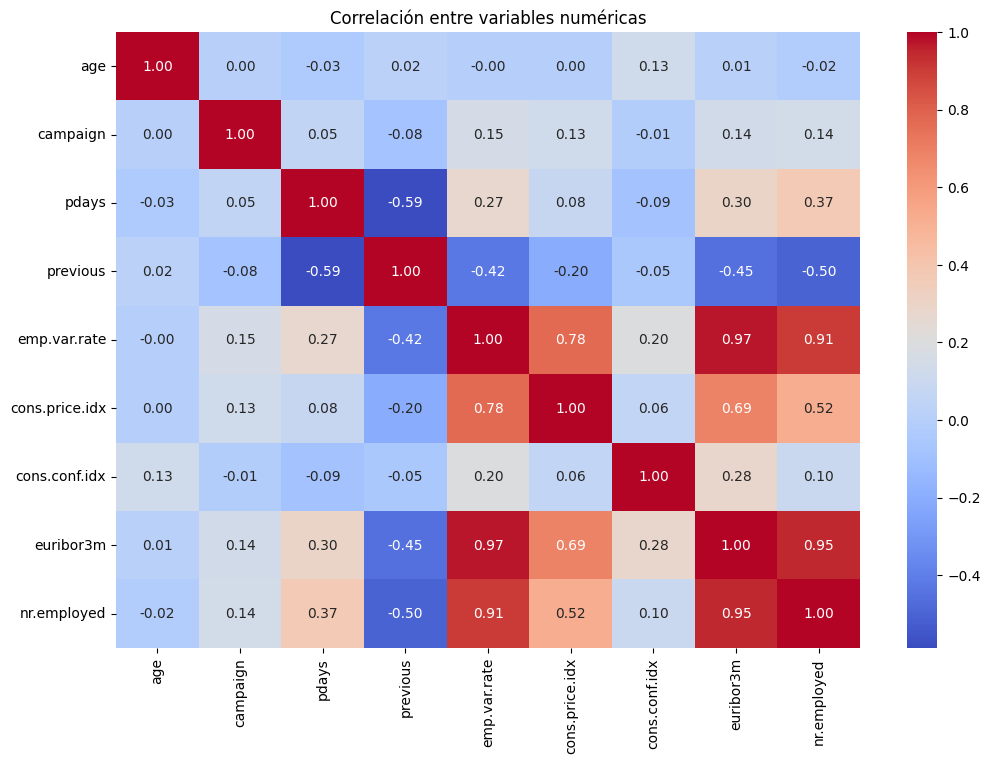

In [94]:
#11. Matriz de correlación variables numéricas
plt.figure(figsize=(12, 8))
sns.heatmap(df[variables_numericas].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlación entre variables numéricas")
plt.show()

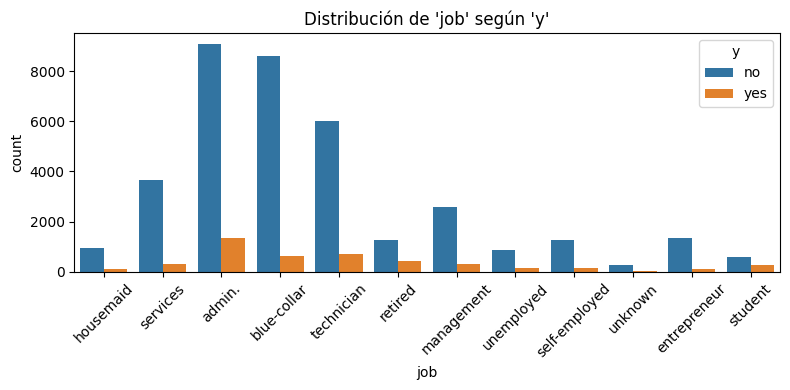

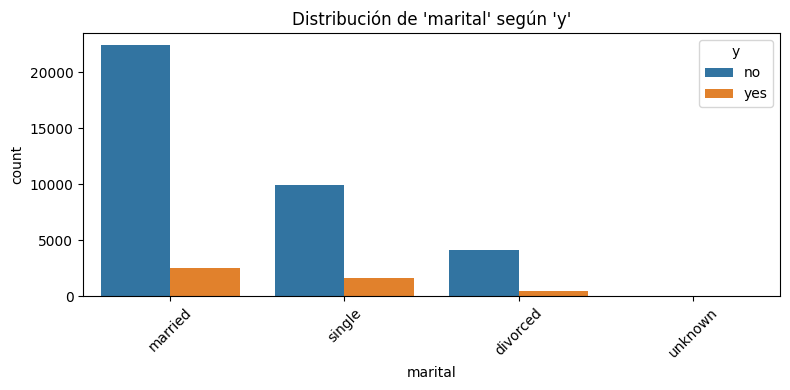

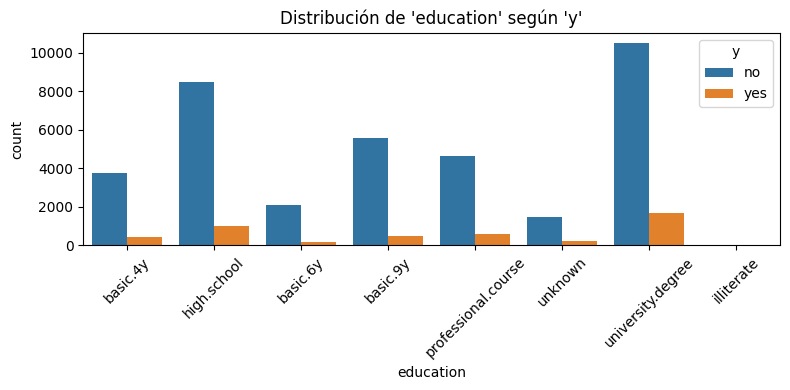

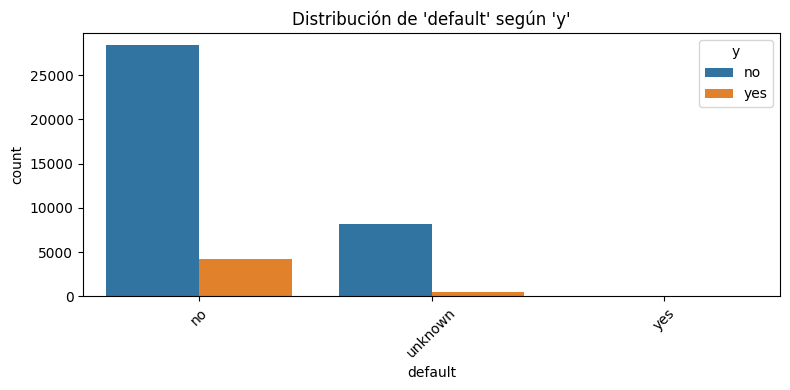

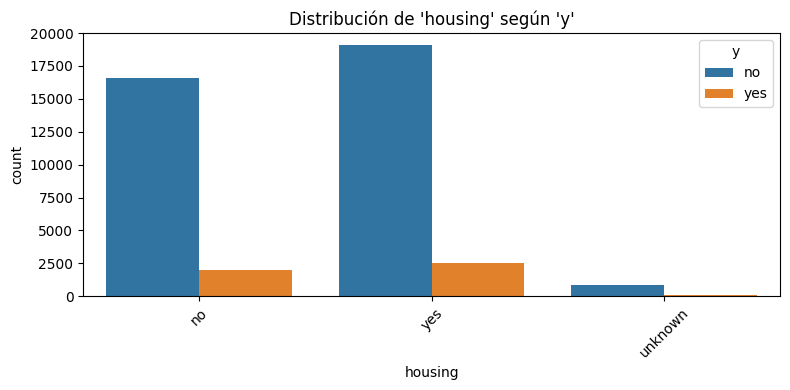

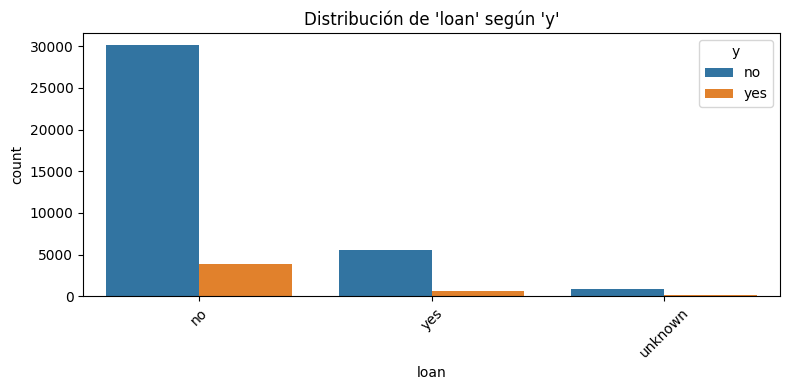

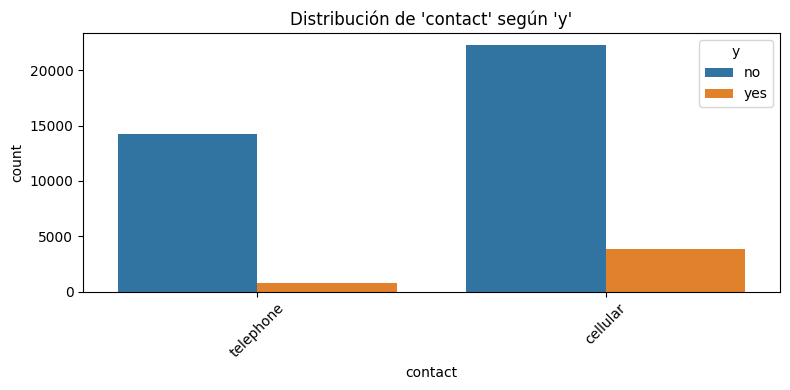

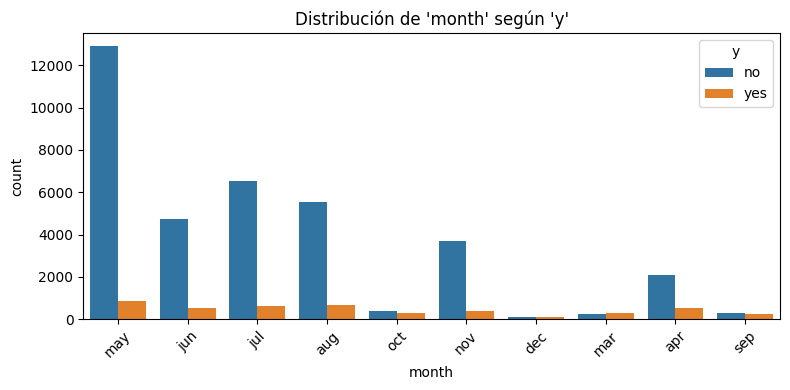

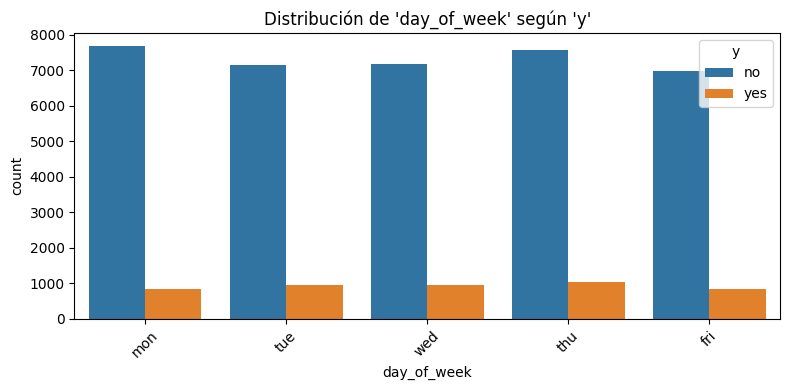

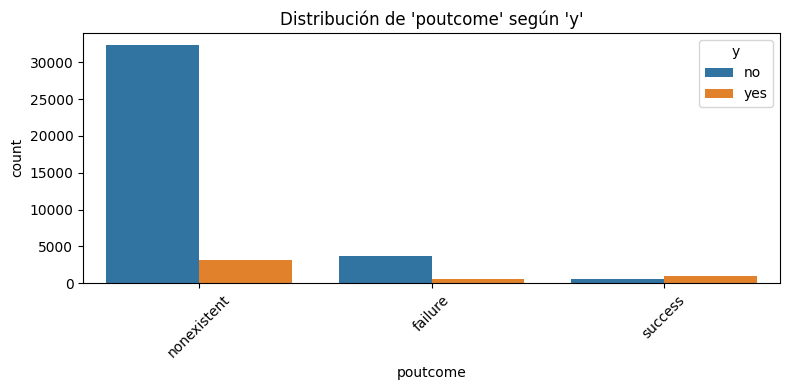

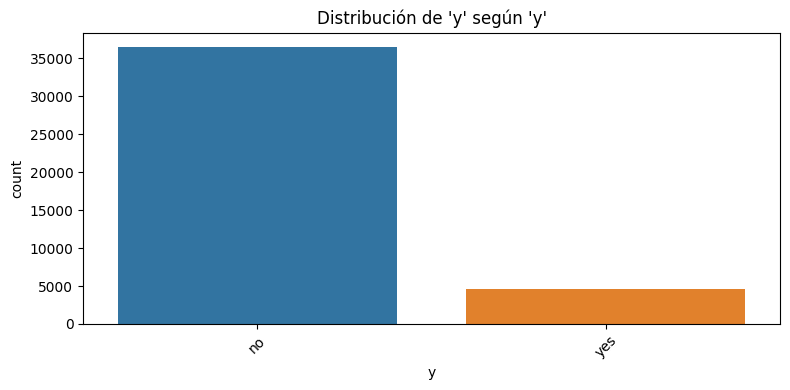

In [95]:
# 12. Visualización de variables categóricas
# En este paso visualizamos la distribución de las variables categóricas, y cómo se relacionan con la variable objetivo 'y'.

# Recorremos las columnas categóricas
variables_categoricas = df.select_dtypes(include=['object']).columns.tolist()
for col in variables_categoricas:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df, hue='y')
    plt.title(f"Distribución de '{col}' según 'y'")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Bloque 5: Ingeniería de características sobre edad

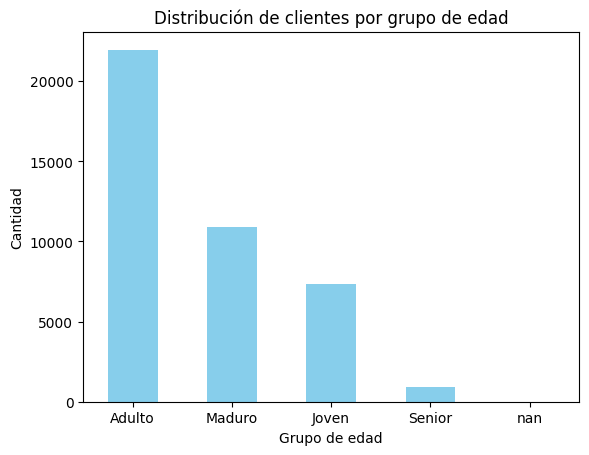

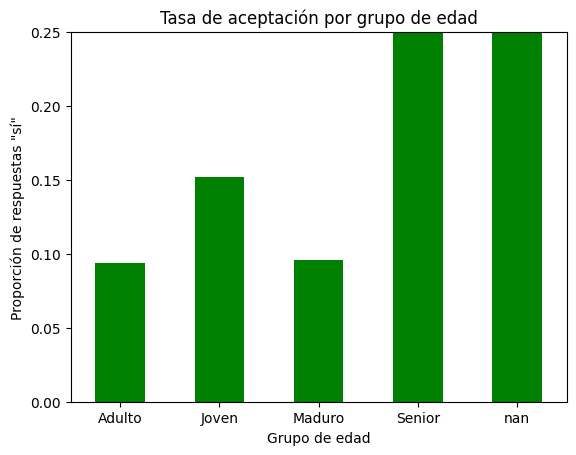

In [96]:
# 13. Creación de variable categórica 'age_group'
# Agrupamos la edad en tramos antes de definir X/y y actualizar variables categóricas

df['age_group'] = pd.cut(df['age'], bins=[17, 30, 45, 60, 100],labels=['Joven', 'Adulto', 'Maduro', 'Senior'])
df['age_group'] = df['age_group'].astype(str)  # Aseguramos que es string y no categoría con nulos

# Conteo de clientes por grupo de edad
df['age_group'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribución de clientes por grupo de edad')
plt.xlabel('Grupo de edad')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.show()

# Tasa de respuesta positiva ('yes') por grupo de edad
age_response = df.groupby('age_group')['y'].value_counts(normalize=True).unstack()['yes']
age_response.plot(kind='bar', color='green')
plt.title('Tasa de aceptación por grupo de edad')
plt.xlabel('Grupo de edad')
plt.ylabel('Proporción de respuestas "sí"')
plt.ylim(0, 0.25)  # Ajusta el límite según los resultados
plt.xticks(rotation=0)
plt.show()

# Bloque 6: Preparación para modelado

In [97]:
# 14. Preparar datos antes del pipeline
df['y_binaria'] = df['y'].map({'no': 0, 'yes': 1})
X = df.drop(columns=['y', 'y_binaria'])
y = df['y_binaria']

# Bloque 7: Comprobación de nulos

In [98]:
# 15. Verificación de valores nulos en el DataFrame
# En este paso comprobamos si existen columnas con valores nulos y cuántas filas están afectadas.
# Aunque inicialmente no se detectaron nulos, es una buena práctica hacerlo tras cualquier transformación.

# Calculamos cuántos valores nulos hay por columna
faltantes = df.isnull().sum()
faltantes = faltantes[faltantes > 0]  # Filtramos solo columnas con al menos un nulo
faltantes_pct = (faltantes / len(df) * 100).sort_values(ascending=False)

# Mostramos un resumen claro si existen valores nulos
if not faltantes.empty:
    resumen_nulos = pd.DataFrame({
        'Nº de nulos': faltantes,
        'Porcentaje': faltantes_pct.round(2)
    })
    display(resumen_nulos)
else:
    print("No se detectaron valores nulos por columna.")

# Contamos cuántas filas tienen al menos un valor nulo
n_filas_con_nulos = df.isnull().any(axis=1).sum()
print(f"Filas con al menos un valor nulo: {n_filas_con_nulos}")

No se detectaron valores nulos por columna.
Filas con al menos un valor nulo: 0


# Bloque 8: Definición de pipeline

In [99]:
# 16. Definición del pipeline de preprocesamiento y modelo
# Usamos ColumnTransformer para aplicar transformaciones a variables numéricas y categóricas.
# Encapsulamos todo junto con un modelo de regresión logística dentro de un Pipeline.

variables_numericas = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
variables_categoricas = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocesador = ColumnTransformer(transformers=[
    ('num', StandardScaler(), variables_numericas),
    ('cat', OneHotEncoder(handle_unknown='ignore'), variables_categoricas)
])

pipeline = Pipeline(steps=[
    ('preprocesado', preprocesador),
    ('modelo', LogisticRegression(max_iter=1000))
])

print("✅ Pipeline definido correctamente.")

✅ Pipeline definido correctamente.


# Bloque 9: Split y filtrado de test

In [100]:
# 17. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Restaurar 'age' y aplicar Z-score
df['age'] = pd.to_numeric(df['age'], errors='coerce')
X_test['age'] = df.loc[X_test.index, 'age']
z_scores = np.abs(zscore(X_test['age']))
X_test_filtrado = X_test[z_scores < 3]
y_test_filtrado = y_test.loc[X_test_filtrado.index]

# Bloque 10: Entrenamiento y evaluación inicial

In [101]:
# 18. Entrenar modelo
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [102]:
# 19. Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



Accuracy: 0.8984944147644488
[[7203  105]
 [ 731  197]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7308
           1       0.65      0.21      0.32       928

    accuracy                           0.90      8236
   macro avg       0.78      0.60      0.63      8236
weighted avg       0.88      0.90      0.87      8236



# Bloque 11: Análisis avanzado

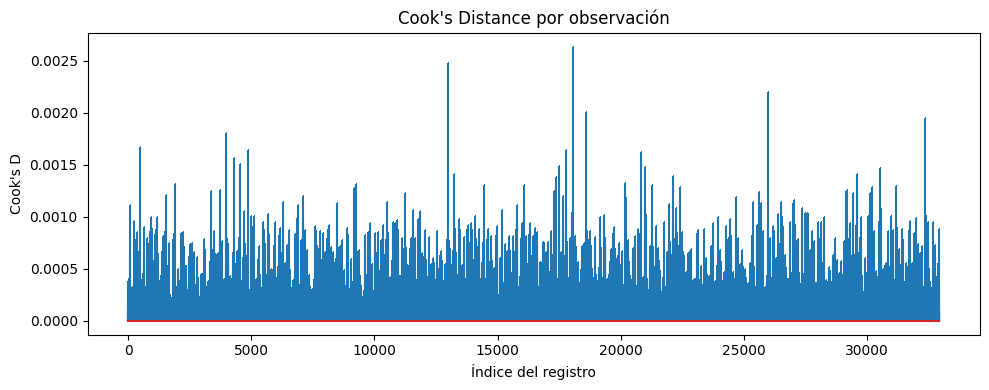

In [103]:
# 20. Distancia de Cook
X_stats = X_train.select_dtypes(include=['number']).copy()
X_stats = sm.add_constant(X_stats)
y_stats = pd.to_numeric(y_train, errors='coerce')
modelo = sm.OLS(y_stats, X_stats).fit()
influencia = modelo.get_influence()
cooks_d = influencia.cooks_distance[0]
umbral = 4 / len(X_stats)
puntos_influyentes = np.where(cooks_d > umbral)[0]

plt.figure(figsize=(10, 4))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.title("Cook's Distance por observación")
plt.xlabel("Índice del registro")
plt.ylabel("Cook's D")
plt.tight_layout()
plt.show()

In [104]:
# 21. Filtrar conjunto de test con Z-score coherentemente
# (Nota: 'duration' ya eliminada previamente, adaptamos a 'age')
z_scores = np.abs(zscore(X_test['age']))
X_test_filtrado = X_test[z_scores < 3]
y_test_filtrado = y_test.loc[X_test_filtrado.index]

In [105]:
# 22. Ingeniería de características: Grupos de edad
df['age_group'] = pd.cut(df['age'], bins=[17,30,45,60,100], labels=['Joven','Adulto','Maduro','Senior']).astype(str)
variables_categoricas.append('age_group')

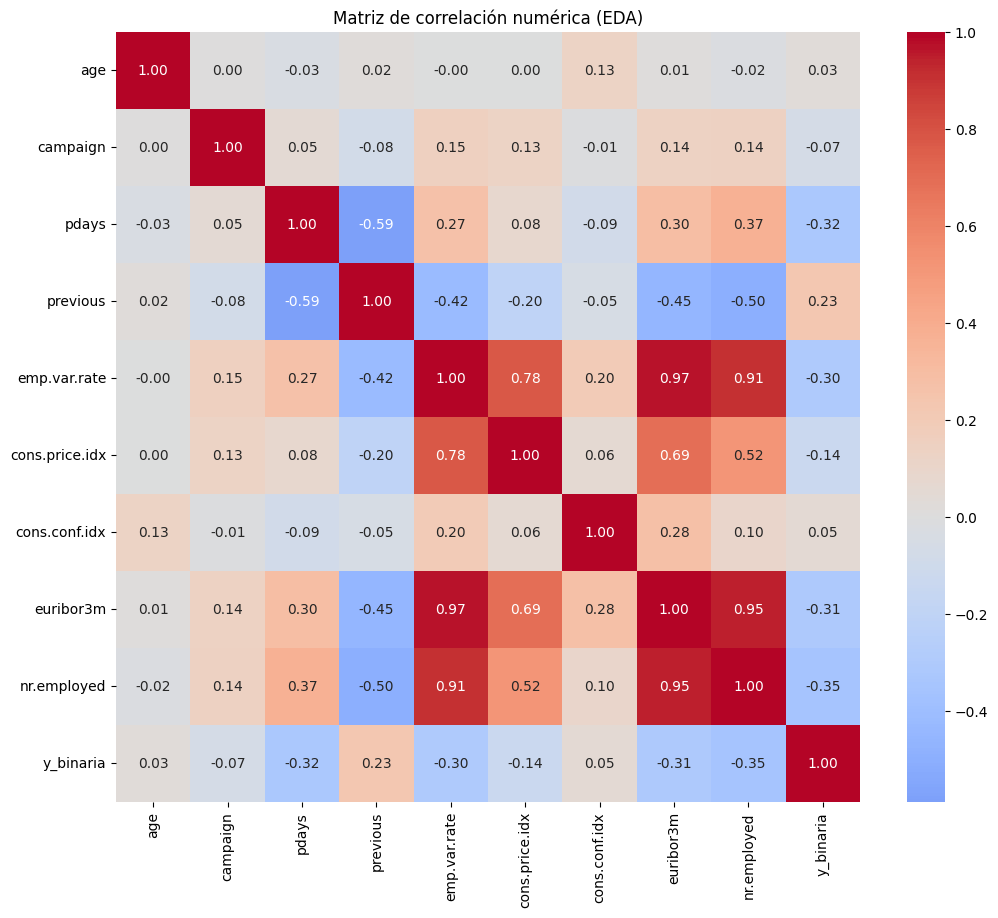

In [106]:
# 23. Matriz de correlación actualizada
plt.figure(figsize=(12, 10))
corr = df.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Matriz de correlación numérica (EDA)')
plt.show()

In [107]:
# 24. Multicolinealidad: VIF
X_vif = pd.get_dummies(X_train, drop_first=True)
X_vif = X_vif.select_dtypes(include=[np.number]).dropna()
X_vif = sm.add_constant(X_vif)
vif_df = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print(vif_df.sort_values("VIF", ascending=False))

         Variable            VIF
0           const  526783.247497
8       euribor3m      64.433799
5    emp.var.rate      33.197857
9     nr.employed      31.598122
6  cons.price.idx       6.342917
7   cons.conf.idx       2.642444
4        previous       1.794704
3           pdays       1.616966
2        campaign       1.032819
1             age       1.019561


In [108]:
# 25. Reducir multicolinealidad
variables_a_eliminar = ['emp.var.rate', 'nr.employed']
X_train_reducido = X_train.drop(columns=variables_a_eliminar, errors='ignore')
X_test_reducido = X_test.drop(columns=variables_a_eliminar, errors='ignore')

print(f"Variables eliminadas: {variables_a_eliminar}")

Variables eliminadas: ['emp.var.rate', 'nr.employed']


In [109]:
# 26. Selección de características con XGBoost
X_encoded = pd.get_dummies(X, drop_first=True)
model_xgb = xgb.XGBClassifier(n_estimators=100, random_state=42)
model_xgb.fit(X_encoded, y)

importancias = model_xgb.feature_importances_
features = X_encoded.columns
importancia_df = pd.DataFrame({'Variable': features, 'Importancia': importancias})
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

vars_seleccionadas = importancia_df[importancia_df['Importancia'] > 0.01]['Variable'].tolist()
print(f"Variables seleccionadas (>1%): {len(vars_seleccionadas)}")

X_filtrado = X_encoded[vars_seleccionadas]

Variables seleccionadas (>1%): 10


# Bloque 12: Nuevo pipeline/modelo y tuning

In [110]:
# 27. Nuevo preprocesador para el pipeline
preprocesador = ColumnTransformer(transformers=[
    ('num', StandardScaler(), variables_numericas),
    ('cat', OneHotEncoder(handle_unknown='ignore'), variables_categoricas)
])

In [111]:
# 28. Nuevo split y modelo ajustado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipeline = Pipeline(steps=[
    ('preprocesado', preprocesador),
    ('modelo', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
pipeline.fit(X_train, y_train)

,steps,"[('preprocesado', ...), ('modelo', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [112]:
# 29. Tuning de hiperparámetros
param_dist = {'modelo__C': loguniform(0.001, 100), 'modelo__solver': ['liblinear', 'lbfgs']}
random_search = RandomizedSearchCV(pipeline, param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

param_grid = {'modelo__C': [0.1, 1, 10], 'modelo__solver': ['liblinear']}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

modelo_final = grid_search.best_estimator_
print("Mejor modelo encontrado:", grid_search.best_params_)

Mejor modelo encontrado: {'modelo__C': 10, 'modelo__solver': 'liblinear'}


# Bloque 13: Evaluación final y ajustes

              precision    recall  f1-score   support

           0       0.95      0.85      0.90      7308
           1       0.36      0.64      0.46       928

    accuracy                           0.83      8236
   macro avg       0.65      0.75      0.68      8236
weighted avg       0.88      0.83      0.85      8236



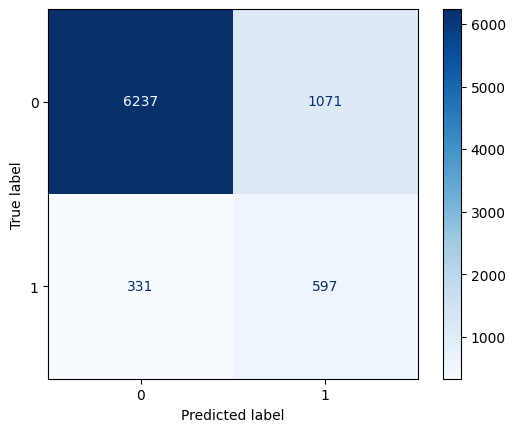

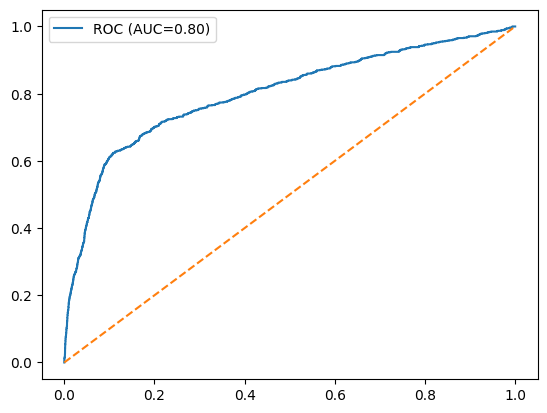

In [113]:
# 30. Evaluación completa
print(classification_report(y_test, modelo_final.predict(X_test)))
ConfusionMatrixDisplay.from_estimator(modelo_final, X_test, y_test, cmap='Blues')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, modelo_final.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f"ROC (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'--'); plt.legend(); plt.show()

In [114]:
# 31. Ajustar umbral de clasificación (0.4)
y_pred_umbral = (modelo_final.predict_proba(X_test)[:,1]>=0.4).astype(int)
print(classification_report(y_test,y_pred_umbral))

              precision    recall  f1-score   support

           0       0.96      0.75      0.84      7308
           1       0.27      0.73      0.40       928

    accuracy                           0.75      8236
   macro avg       0.61      0.74      0.62      8236
weighted avg       0.88      0.75      0.79      8236



# Bloque 14: Guardado, predicción y exportación

In [115]:
# 32. Guardar y cargar modelo final
joblib.dump(modelo_final, 'modelo_regresion_logistica_final.pkl')
pipeline = joblib.load('modelo_regresion_logistica_final.pkl')

In [116]:
# 33. Simulación de un nuevo cliente (debe incluir todas las columnas del modelo)
nuevo_cliente = pd.DataFrame({
    'age': [34],
    'job': ['technician'],
    'marital': ['married'],
    'education': ['tertiary'],
    'default': ['no'],
    'housing': ['yes'],
    'loan': ['no'],
    'contact': ['cellular'],
    'month': ['jun'],
    'day_of_week': ['wed'],
    'campaign': [2],
    'pdays': [-1],
    'previous': [0],
    'poutcome': ['unknown'],
    'cons.price.idx': [93.918],
    'cons.conf.idx': [-42.7],
    'euribor3m': [4.961],
    'nr.employed': [5228.1],      
    'emp.var.rate': [-1.8],       
    'age_group': ['Adulto']
})

In [117]:
# 34. Predicción para el nuevo cliente
prediccion = pipeline.predict(nuevo_cliente)
probabilidad = pipeline.predict_proba(nuevo_cliente)[:, 1]
print("Predicción (0=No, 1=Sí):", prediccion)
print("Probabilidad de éxito:", probabilidad)

Predicción (0=No, 1=Sí): [1]
Probabilidad de éxito: [0.99263337]


In [118]:
# 35. Exportar clientes recomendados
clientes_recomendados = X_test.copy()
clientes_recomendados['probabilidad_exito'] = modelo_final.predict_proba(X_test)[:, 1]
clientes_recomendados = clientes_recomendados[clientes_recomendados['probabilidad_exito'] >= 0.50]
clientes_recomendados.to_csv("clientes_recomendados.csv", index=False)
print("Archivo 'clientes_recomendados.csv' generado con éxito.")


Archivo 'clientes_recomendados.csv' generado con éxito.


In [119]:
print(f"Total de clientes recomendados: {len(clientes_recomendados)}")
print(clientes_recomendados.head())

Total de clientes recomendados: 1668
       age          job  marital            education  default housing loan  \
40844   30      student   single  professional.course       no     yes   no   
29657   53  blue-collar  married          high.school  unknown     yes   no   
36097   25       admin.   single    university.degree       no     yes  yes   
41104   46       admin.   single          high.school       no     yes   no   
39096   35   unemployed  married  professional.course       no     yes  yes   

        contact month day_of_week  ...  pdays  previous     poutcome  \
40844  cellular   sep         tue  ...      6         1      success   
29657  cellular   apr         mon  ...    999         0  nonexistent   
36097  cellular   may         tue  ...    999         0  nonexistent   
41104  cellular   nov         mon  ...    999         2      failure   
39096  cellular   dec         thu  ...    999         1      failure   

      emp.var.rate  cons.price.idx  cons.conf.idx  euri